In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import math
warnings.filterwarnings('ignore')

In [35]:
data = pd.read_csv('spotify_songs.csv')
data.columns

Index(['track_id', 'track_name', 'track_artist', 'track_popularity',
       'track_album_id', 'track_album_name', 'track_album_release_date',
       'playlist_name', 'playlist_id', 'playlist_genre', 'playlist_subgenre',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms'],
      dtype='object')

In [36]:
# Veri setindeki sütun adlarını yeniden adlandırma işlemi yapıldı.
data.rename(columns={'track_popularity': 'popularity', 
                     'track_artist': 'artist', 
                     'track_name': 'name', 
                     'track_album_id': 'album_id', 
                     'track_album_name': 'album_name', 
                     'track_album_release_date': 'album_release_date', 
                     'playlist_genre': 'genre', 
                     'playlist_subgenre': 'subgenre'}, inplace=True)

In [37]:

def encode_playlist_info(df):
    """
    Spotify veri setinde playlist bilgilerini anlamlı sayısal temsillere dönüştürür.
    - playlist_subgenre sütunlarını one-hot encode eder.
    - Her şarkının yer aldığı playlist sayısını (playlist_count) hesaplar.
    - Gereksiz playlist sütunlarını kaldırır.

    Parametre:
        df (pd.DataFrame): Orijinal Spotify veri seti.

    Dönüş:
        merged_df (pd.DataFrame): Yeni özellikler eklenmiş, playlist sütunları işlenmiş DataFrame.
    """

    df = df.copy()

    # --- 1️⃣ Playlist count: bir şarkı kaç farklı playlist'te var ---
    playlist_count = df.groupby('track_id')['playlist_id'].nunique()
    df['playlist_count'] = df['track_id'].map(playlist_count)

    # --- 2️⃣ Subgenre encoding: one-hot (multi-label) ---
    subgenre_dummies = pd.get_dummies(df['subgenre'], prefix='subgenre', dtype=int)

    # Şarkı bazında grupla (aynı şarkı birden fazla subgenre'de olabilir)
    subgenre_features = (
        pd.concat([df[['track_id']], subgenre_dummies], axis=1)
        .groupby('track_id', as_index=False)
        .max()
    )

    # --- 3️⃣ Şarkı bazında unique satır oluştur ve gereksiz kolonları sil ---
    df = df.drop(columns=['playlist_name', 'playlist_id', 'genre', 'subgenre'])
    base_df = df.drop_duplicates(subset=['track_id'])

    # --- 4️⃣ Merge işlemi ---
    merged_df = base_df.merge(subgenre_features, on='track_id', how='left')

    print(f"✅ encode_playlist_info tamamlandı → Yeni shape: {merged_df.shape}")
    print(f"ℹ️ Genre sütunu sayısı: {len([c for c in merged_df.columns if c.startswith('genre_')])}")
    print(f"ℹ️ Subgenre sütunu sayısı: {len([c for c in merged_df.columns if c.startswith('subgenre_')])}")

    return merged_df


# Spotify veri setini işleme
data = encode_playlist_info(data)


✅ encode_playlist_info tamamlandı → Yeni shape: (28356, 44)
ℹ️ Genre sütunu sayısı: 0
ℹ️ Subgenre sütunu sayısı: 24


In [38]:
data[data['track_id'].duplicated()]

,track_id,name,artist,popularity,album_id,album_name,album_release_date,danceability,energy,key,...,subgenre_new jack swing,subgenre_permanent wave,subgenre_pop edm,subgenre_post-teen pop,subgenre_progressive electro house,subgenre_reggaeton,subgenre_southern hip hop,subgenre_trap,subgenre_tropical,subgenre_urban contemporary


In [39]:
# TO ADD ALBUM RELEASE YEAR AS A FEATURE. THE YEAR RELEASED IS EXTRACTED FROM NOW 
# Albüm yayınlanma tarihinden yaş hesaplama
from datetime import datetime
# Mevcut yılı al
current_year = datetime.now().year
# album_release_date'i datetime'a çevir ve yılı çıkar
data['album_release_date'] = pd.to_datetime(data['album_release_date'], errors='coerce')
data['album_age'] = current_year - data['album_release_date'].dt.year
# Önce geçerli değerlerden mod hesapla
mode_value = data['album_age'].mode()[0]
# album_release_date boş olan satırlar için album_age'i mod ile doldur
data.loc[data['album_release_date'].isna(), 'album_age'] = mode_value
# NaN değerleri kontrol et
print(f"Mod değeri: {mode_value}")
print(f"NaN değer sayısı: {data['album_age'].isna().sum()}")
print(f"Albüm yaşı özeti:\n{data['album_age'].describe()}")

Mod değeri: 6.0
NaN değer sayısı: 0
Albüm yaşı özeti:
count    28356.000000
mean        12.487657
std         10.070509
min          5.000000
25%          6.000000
50%          8.000000
75%         14.000000
max         68.000000
Name: album_age, dtype: float64


In [40]:
# Numerik sütunlar listesi çıkarıldı.
numeric_cols = ['popularity', 'danceability', 'energy', 'valence', 'tempo', 'loudness',
                'acousticness', 'instrumentalness', 'speechiness', 'liveness', 'duration_ms']

In [41]:
# Hangi sütunlarda NaN değerleri var kontrol et
print("NaN değerleri içeren sütunlar:")
nan_counts = data.isnull().sum()
nan_cols = nan_counts[nan_counts > 0]
if len(nan_cols) > 0:
    print(nan_cols)
else:
    print("Hiç NaN değer yok!")

print("\n" + "="*50)

# Numerik sütunlar için median ile doldur
numeric_cols_to_fill = data.select_dtypes(include=[np.number]).columns
for col in numeric_cols_to_fill:
    if data[col].isna().any():
        print(f"'{col}' sütunu dolduruldu (mod: {data[col].mode()[0]})")
        data[col].fillna(data[col].mode()[0], inplace=True)

# String sütunlar için "Unknown" kullan
string_cols = data.select_dtypes(include=['object']).columns
for col in string_cols:
    if data[col].isna().any():
        print(f"'{col}' sütunu 'Unknown' ile dolduruldu")
        data[col].fillna("Unknown", inplace=True)

rows_with_null = data[data.isnull().any(axis=1)]
print(f"\nKalan NaN satır sayısı: {len(rows_with_null)}")

NaN değerleri içeren sütunlar:
name                     4
artist                   4
album_name               4
album_release_date    1681
dtype: int64

'name' sütunu 'Unknown' ile dolduruldu
'artist' sütunu 'Unknown' ile dolduruldu
'album_name' sütunu 'Unknown' ile dolduruldu

Kalan NaN satır sayısı: 1681


In [42]:
# Tüm numerik sütunların değer aralıklarını kontrol et
print("TÜM SÜTUNLARIN DEĞER ARALIKLARI")
# Numerik sütunları al
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
# Her sütun için min, max, range bilgisini göster
range_info = pd.DataFrame({
    'Column': numeric_cols,
    'Min': [data[col].min() for col in numeric_cols],
    'Max': [data[col].max() for col in numeric_cols],
    'Range': [data[col].max() - data[col].min() for col in numeric_cols],
    'Mean': [data[col].mean() for col in numeric_cols],
    'Std': [data[col].std() for col in numeric_cols]
})

# Range'e göre sırala (büyükten küçüğe)
range_info = range_info.sort_values('Range', ascending=False)

# Normalize edilmesi gereken sütunları belirle (0-1 aralığında olmayanlar)
needs_normalization = range_info[(range_info['Min'] < 0) | (range_info['Max'] > 1)]
print("NORMALİZE EDİLMESİ GEREKEN SÜTUNLAR (0-1 dışında):")
if len(needs_normalization) > 0:
    print(needs_normalization[['Column', 'Min', 'Max', 'Range']].to_string(index=False))
else:
    print("Tüm sütunlar 0-1 aralığında! ✓")


TÜM SÜTUNLARIN DEĞER ARALIKLARI
NORMALİZE EDİLMESİ GEREKEN SÜTUNLAR (0-1 dışında):
        Column      Min        Max      Range
   duration_ms 4000.000 517810.000 513810.000
         tempo    0.000    239.440    239.440
    popularity    0.000    100.000    100.000
     album_age    5.000     68.000     63.000
      loudness  -46.448      1.275     47.723
           key    0.000     11.000     11.000
playlist_count    1.000      8.000      7.000


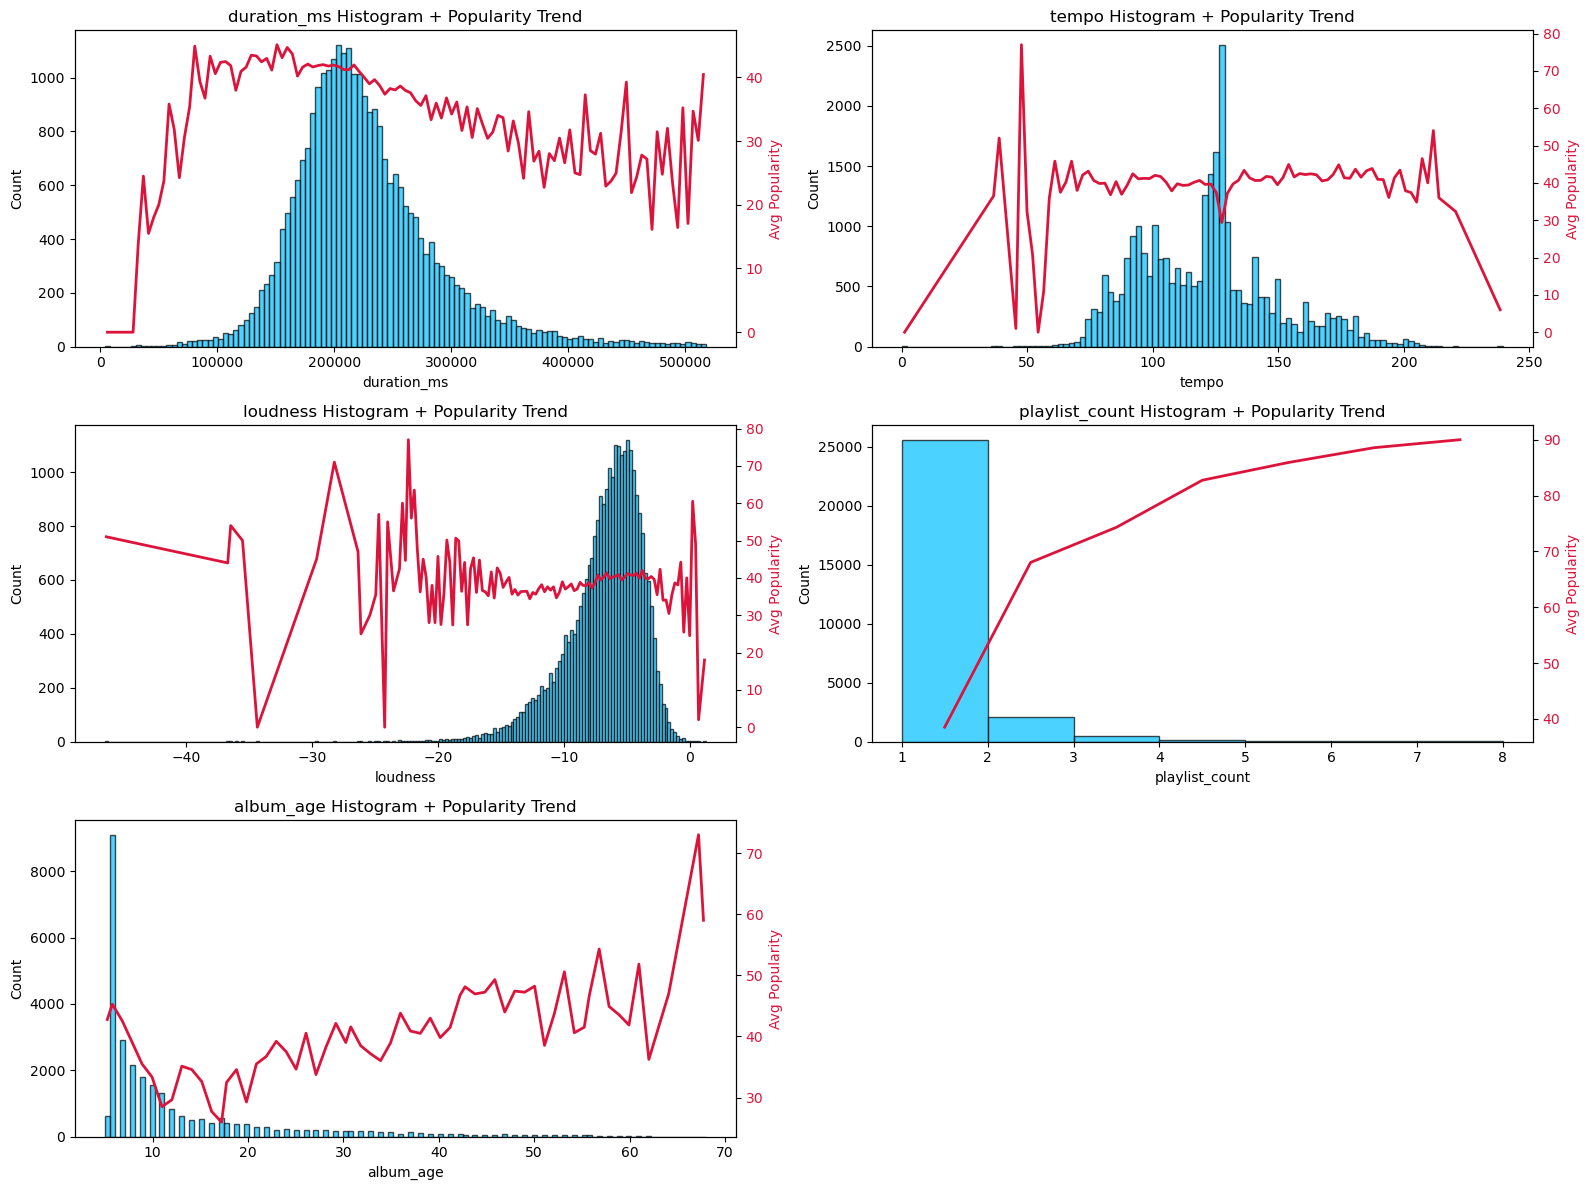

In [43]:
# Yeni dağılım grafikleri gösterildi.
cols_to_scale = ['duration_ms', 'tempo', 'loudness', 'playlist_count', 'album_age']
n_cols = 2
n_rows = math.ceil(len(cols_to_scale) / n_cols)

fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16, n_rows * 4))
ax = ax.flatten()
cols_to_scale = cols_to_scale

for i, col in enumerate(cols_to_scale):
    # Histogram (önce otomatik bin aralıklarını al)
    counts, bins, patches = ax[i].hist(data[col], bins='auto', color='deepskyblue', edgecolor='black', alpha=0.7)
    
    # Popularity ortalamaları (bin aralıklarına göre)
    bin_labels = pd.cut(data[col], bins=bins, include_lowest=True)
    grouped = data.groupby(bin_labels)['popularity'].mean().dropna()
    centers = [interval.mid for interval in grouped.index]
    bin_means = grouped.values

    # Popularity çizgisi
    ax2 = ax[i].twinx()
    ax2.plot(centers, bin_means, color='crimson', linewidth=2)
    ax2.set_ylabel('Avg Popularity', color='crimson')
    ax2.tick_params(axis='y', labelcolor='crimson')

    ax[i].set_title(f'{col} Histogram + Popularity Trend')
    ax[i].set_xlabel(col)
    ax[i].set_ylabel('Count')

# Boş kalan hücreleri gizle
for j in range(i + 1, len(ax)):
    fig.delaxes(ax[j])

plt.tight_layout()
plt.show()

In [44]:
data["album_age_log"] = np.log1p(data["album_age"])

In [ ]:
def playlist_binner(x):
    if x <= 1:
        return 0.0
    elif x == 2:
        return 0.5
    else:
        return 1.0

data["playlist_count"] = data["playlist_count"].apply(playlist_binner)

In [46]:
cols_to_scale = ['duration_ms', 'tempo', 'loudness', 'album_age_log']

In [47]:
# Normalizasyon işlemleri yapıldı:
# Tempo, loudness, duration_ms değer aralıkları geniş olduğu için min-max scaling uygulandı ve diğer feature'lar ile benzer ölçeğe getirildi.
# from sklearn.preprocessing import MinMaxScaler, RobustScaler

# minmax_scaler = MinMaxScaler()
# robust_scaler = RobustScaler()

# # Fit ve transform işlemi
# data[cols_to_scale] = minmax_scaler.fit_transform(data[cols_to_scale])

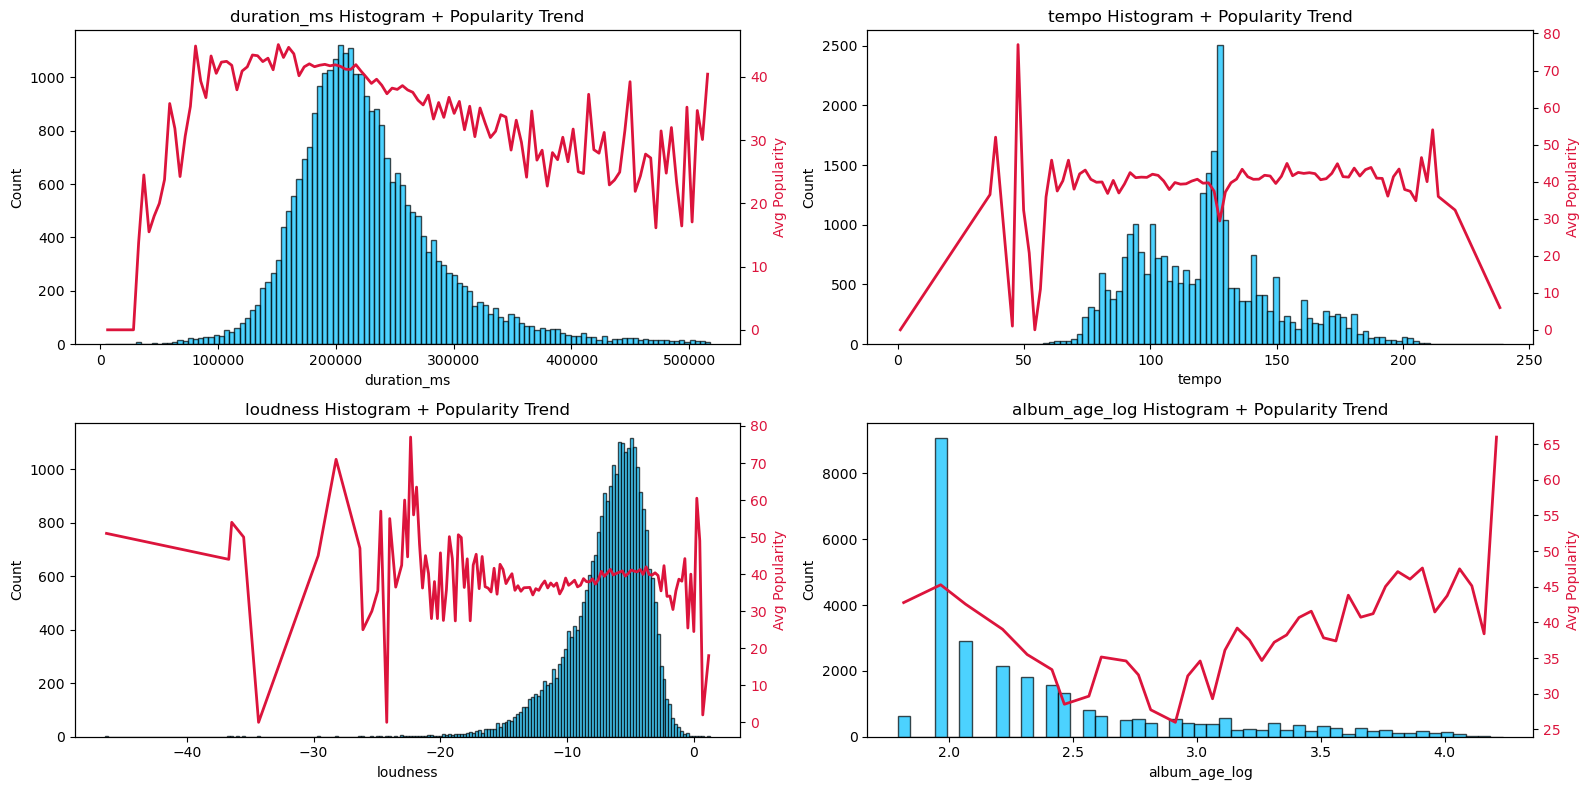

In [48]:
# Yeni dağılım grafikleri gösterildi.
cols_to_plot = cols_to_scale #+ ['playlist_count_final'] 
n_cols = 2
n_rows = math.ceil(len(cols_to_plot) / n_cols)

fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16, n_rows * 4))
ax = ax.flatten()

for i, col in enumerate(cols_to_plot):
    # Histogram (önce otomatik bin aralıklarını al)
    counts, bins, patches = ax[i].hist(data[col], bins='auto', color='deepskyblue', edgecolor='black', alpha=0.7)
    
    # Popularity ortalamaları (bin aralıklarına göre)
    bin_labels = pd.cut(data[col], bins=bins, include_lowest=True)
    grouped = data.groupby(bin_labels)['popularity'].mean().dropna()
    centers = [interval.mid for interval in grouped.index]
    bin_means = grouped.values

    # Popularity çizgisi
    ax2 = ax[i].twinx()
    ax2.plot(centers, bin_means, color='crimson', linewidth=2)
    ax2.set_ylabel('Avg Popularity', color='crimson')
    ax2.tick_params(axis='y', labelcolor='crimson')

    ax[i].set_title(f'{col} Histogram + Popularity Trend')
    ax[i].set_xlabel(col)
    ax[i].set_ylabel('Count')

# Boş kalan hücreleri gizle
for j in range(i + 1, len(ax)):
    fig.delaxes(ax[j])

plt.tight_layout()
plt.show()

In [49]:
print("Önceki column sayısı" + str(len(data.columns)))
print(data.columns)

Önceki column sayısı47
Index(['track_id', 'name', 'artist', 'popularity', 'album_id', 'album_name',
       'album_release_date', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'playlist_count',
       'subgenre_album rock', 'subgenre_big room', 'subgenre_classic rock',
       'subgenre_dance pop', 'subgenre_electro house', 'subgenre_electropop',
       'subgenre_gangster rap', 'subgenre_hard rock', 'subgenre_hip hop',
       'subgenre_hip pop', 'subgenre_indie poptimism',
       'subgenre_latin hip hop', 'subgenre_latin pop', 'subgenre_neo soul',
       'subgenre_new jack swing', 'subgenre_permanent wave',
       'subgenre_pop edm', 'subgenre_post-teen pop',
       'subgenre_progressive electro house', 'subgenre_reggaeton',
       'subgenre_southern hip hop', 'subgenre_trap', 'subgenre_tropical',
       'subgenre_urban contemporary', 'album_age', 'album_age_log',
      

In [50]:
# Modele dahil edilmeyecek sütunlar kaldırıldı.
columns_to_drop = ['album_id', 
                   'album_name', 
                   'name', 
                   'album_release_date', 
                   'track_id',
                   'key',
                   'album_age'
]
genres = [c for c in data.columns if c.startswith('genre_')]
data.drop(genres, axis=1, inplace=True)
data = data.drop(columns=columns_to_drop)
print("Columns after drop " +  str(data.columns))
print(len(data.columns))

Columns after drop Index(['artist', 'popularity', 'danceability', 'energy', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'playlist_count',
       'subgenre_album rock', 'subgenre_big room', 'subgenre_classic rock',
       'subgenre_dance pop', 'subgenre_electro house', 'subgenre_electropop',
       'subgenre_gangster rap', 'subgenre_hard rock', 'subgenre_hip hop',
       'subgenre_hip pop', 'subgenre_indie poptimism',
       'subgenre_latin hip hop', 'subgenre_latin pop', 'subgenre_neo soul',
       'subgenre_new jack swing', 'subgenre_permanent wave',
       'subgenre_pop edm', 'subgenre_post-teen pop',
       'subgenre_progressive electro house', 'subgenre_reggaeton',
       'subgenre_southern hip hop', 'subgenre_trap', 'subgenre_tropical',
       'subgenre_urban contemporary', 'album_age_log', 'playlist_count_final'],
      dtype='object')
40


In [51]:
# İşlenmiş veriyi kaydet
data.to_csv('final_data.csv', index=False)
print(f"✅ Veri kaydedildi: final_data.csv")
print(f"📊 Shape: {data.shape}")
print(f"📋 Sütun sayısı: {len(data.columns)}")

✅ Veri kaydedildi: final_data.csv
📊 Shape: (28356, 40)
📋 Sütun sayısı: 40
